# Results of feature importance evaluations

## Imports

In [1]:
## generals
import pandas as pd
import numpy as np
import timeit
from functools import partial
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time

## hoggorm
import hoggorm as ho 

##sklearn
from sklearn.cross_decomposition import PLSRegression
import sklearn.datasets
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## mlxtend 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

##selfmade
from VIP import VIP
from sMCf import sMC
from IPW import IPW


## VIP

### intuitive vrs implemented

In [2]:
def VIP_implemented(pls,opt=None,p=None):
    """
    Computes the importances to the data given

    Get a quantified importance value for each parameter in the matrix X 
    a set of column vectors equal in length to the number of variables 
    included in the model. It contains one column of VIP scores for each 
    predicted y-block column.

    Parameters
    ---------- 
    pls : object
        object from PLS regression with atributes y_loadings_, x_scores_
        and x_weights_.

    opt : int
        optimal number of components of PLS model.

    p : int
        number of variables in PLS model.


    Returns
    -------
    :returns value: a nx1 vector, where n are the number of features in x 
    :type value: vector

    """ 
    pls = pls
    p = len(pls.coef_) if p is None else p
    opt = None if opt is None else opt

    q = pls.y_loadings_
    t = pls.x_scores_
    W = pls.x_weights_

    WW = np.divide(W*W ,np.ones((p,1))*sum(W*W)) # evt np.sum(W*W,axis=0)
    Q2TT = (np.dot(np.dot((q*q)[0:opt],t[:,0:opt].T),t[:,0:opt]))
    importances = np.sqrt(p*np.sum(np.ones((p,1))*Q2TT*WW[:,:opt],axis=1)/np.sum(Q2TT))

    return importances
    

def vip_git(model):
    """
    Aquired from https://github.com/scikit-learn/scikit-learn/issues/7050 
    """
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        #weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        #weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        #weight = np.divide(w[i,:],np.linalg.norm(w))**2
        #inni = 2*s.T @np.divide(w[i,:],np.linalg.norm(w))**2
        #vips[i] = np.sqrt(p*(inni)/total_s)
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
        #vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

In [3]:
data = sklearn.datasets.load_boston()
X = data['data']
y = data['target']
pls = PLSRegression()
pls.fit(X,y)
vip1 = VIP_implemented(pls)
vip2 = vip_git(pls)

### VIP scores

In [4]:
np.round(vip1,14) == np.round(vip2,14)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

### Speed

In [5]:
times1 = timeit.Timer(partial(VIP_implemented, pls)).repeat(3, 1000)
times2 = timeit.Timer(partial(vip_git, pls)).repeat(3, 1000)
times1[0] /times2[0]

In [ ]:
time_imp = []
time_git = []
params = [10,50,100,500,1000]#,1000,10000]#,100000]
samples = 506
for no_params in params:
    X_test = np.random.rand(samples,no_params)
    pls.fit(X_test,y)
    time_imp.append(timeit.Timer(partial(VIP_implemented, pls)).repeat(3, 500)[0]) 
    time_git.append(timeit.Timer(partial(vip_git, pls)).repeat(3, 500)[0]) 
    

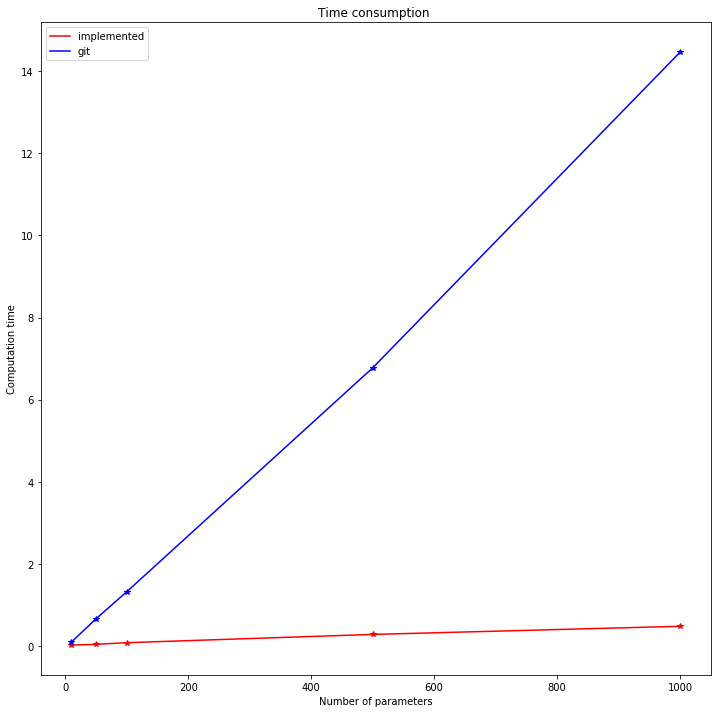

In [51]:
plt.figure(figsize=(12,12))
plt.plot(params,time_imp,'r-',label='implemented')
plt.plot(params,time_imp,'r*')
plt.plot(params,time_git,'b-',label='git')
plt.plot(params,time_git,'b*')

plt.legend(loc='upper left')
plt.title('Time consumption ')
plt.xlabel('Number of parameters')
plt.ylabel('Computation time [s]')
plt.show()

In [54]:
slope_imp = [(time_imp[i]-time_imp[i-1])/(params[i]-params[i-1]) for i in range(1,len(params))]
slope_git = a = [(time_git[i]-time_git[i-1])/(params[i]-params[i-1]) for i in range(1,len(params))]
print(np.mean(slope_imp),np.mean(slope_git),np.mean(slope_imp)/np.mean(slope_git))

## score on Boston Housing Dataset 

### VIP

In [9]:
##Sklearn
Importance_Boston_VIP = pd.DataFrame(index =data['feature_names'])
vip = VIP()
pls_sklearn = PLSRegression(scale=False)
pls_sklearn.fit(X,y)
vip.fit(pls_sklearn)
Importance_Boston_VIP['sklearn pls'] = vip.importances

#Values from Matlab
#Stored values from the VIP process in matlab as vipscores1.mat in the validering folder
Importance_Boston_VIP['Matlab VIP'] =  loadmat('./validering/vipscores1.mat')['values']

# values in python from matlab PLS atributes
#Stored values of X scores as xs.mat and weigts as w.mat from matlab pls method in the validering folder
pls.y_loadings_ = np.array([[101.729463326136,34.0591751857485]]) # extracted y_loadings from matlab
pls.x_scores_ = loadmat('./validering/xs.mat')['Xs']
pls.x_weights_ = loadmat('./validering/W.mat')['W']
vip.fit(pls)
Importance_Boston_VIP['matlab pls'] =vip.importances

#hoggorm PLS
pls_ho =  ho.nipalsPLS1(X, y.reshape(506,1), cvType=['loo'], numComp=2)
vip.fit(pls_ho)
Importance_Boston_VIP['hoggorm pls'] =vip.importances

# extracted from r
Importance_Boston_VIP['R-VIP nipals pls'] = pd.Series([0.171312472, 0.709292976, 0.177492434, 0.005766288,
                                                         0.002431485, 0.056888702, 0.618078627, 0.021928719,
                                                         0.152825608, 3.160193230, 0.095656088, 1.335759260,
                                                         0.496683595] ,index=data['feature_names'])
Importance_Boston_VIP

loo
loo


,sklearn pls,Matlab VIP,matlab pls,hoggorm pls,R-VIP nipals pls
CRIM,0.171312,0.173715,0.173715,0.171312,0.171312
ZN,0.709293,0.716212,0.716212,0.709293,0.709293
INDUS,0.177492,0.179978,0.179978,0.177492,0.177492
CHAS,0.005766,0.005796,0.005796,0.005766,0.005766
NOX,0.002431,0.002465,0.002465,0.002431,0.002431
RM,0.056889,0.057243,0.057243,0.056889,0.056889
AGE,0.618079,0.626494,0.626494,0.618079,0.618079
DIS,0.021929,0.021727,0.021727,0.021929,0.021929
RAD,0.152826,0.150566,0.150566,0.152826,0.152826
TAX,3.160193,3.149395,3.149395,3.160193,3.160193


### sMC

In [10]:
# sklearn
Importance_Boston_sMC = pd.DataFrame(index = data['feature_names'])
pls = PLSRegression(scale=False)
pls.fit(X,y)
smc = sMC()
smc.fit(pls,X)
Importance_Boston_sMC['sklearn pls'] = smc.importances

# values from matlab
#Stored values from the sMC process in matlab as values_smc_1.mat in the validering folder
Importance_Boston_sMC['Matlab sMC'] = loadmat('./validering/values_smc_1_centered.mat')['values'].T 

# values in python from matlab coefficients
# beta values from matlab are stored as beta_1 in the validering folder
pls = PLSRegression()
pls.fit(X,y)
coef = loadmat('./validering/beta_1_centered.mat')['BETA'] 
pls.coef_ = coef[1:] # remove interception
smc = sMC()
smc.fit(pls,X)
Importance_Boston_sMC['Matlab coef']= smc.importances

# hoggorm pls 
#from sMCf import sMC
pls =  ho.nipalsPLS1(X, y.reshape(506,1), cvType=['loo'], numComp=2)
smc.fit(pls,X)
Importance_Boston_sMC['hoggorm pls'] =smc.importances

# Values from R
# extracted from r
Importance_Boston_sMC['R sMC w/nipals pls'] = pd.Series([7.209326e+02, 6.146978e+02, 1.001570e+03, 
                                                         3.883885e+02, 9.805696e+02, 5.421690e+02, 
                                                         7.607644e+02, 2.350280e-03, 2.702975e+01, 
                                                         5.910422e+01, 6.033948e+02, 7.579939e+02, 
                                                         6.270982e+02], index=data['feature_names'])

Importance_Boston_sMC

loo
loo


,sklearn pls,Matlab sMC,Matlab coef,hoggorm pls,R sMC w/nipals pls
CRIM,720.932559,720.932559,720.932559,720.932559,720.93260
ZN,614.697833,614.697833,614.697833,614.697833,614.69780
INDUS,1001.570191,1001.570191,1001.570191,1001.570191,1001.57000
CHAS,388.388473,388.388473,388.388473,388.388473,388.38850
NOX,980.569572,980.569572,980.569572,980.569572,980.56960
RM,542.168964,542.168964,542.168964,542.168964,542.16900
AGE,760.764384,760.764384,760.764384,760.764384,760.76440
DIS,0.002350,0.002350,0.002350,0.002350,0.00235
RAD,27.029754,27.029754,27.029754,27.029754,27.02975
TAX,59.104216,59.104216,59.104216,59.104216,59.10422


### IPW 

#### sklearn

In [11]:
Importance_Boston_IPW = pd.DataFrame(index = data['feature_names'])
r = Ridge()
ipw = IPW()
ipw.fit(r,X,y,threshold=0)
Importance_Boston_IPW['sklearn Ridge'] = ipw.importances

In [12]:
Importance_Boston_IPW

,sklearn Ridge
CRIM,1.799166e-03
ZN,1.141085e-01
INDUS,1.665880e-10
CHAS,1.910537e-13
NOX,3.736411e-26
RM,1.713835e-05
AGE,1.381398e-01
DIS,1.086916e-03
RAD,3.639848e-02
TAX,3.423726e-01


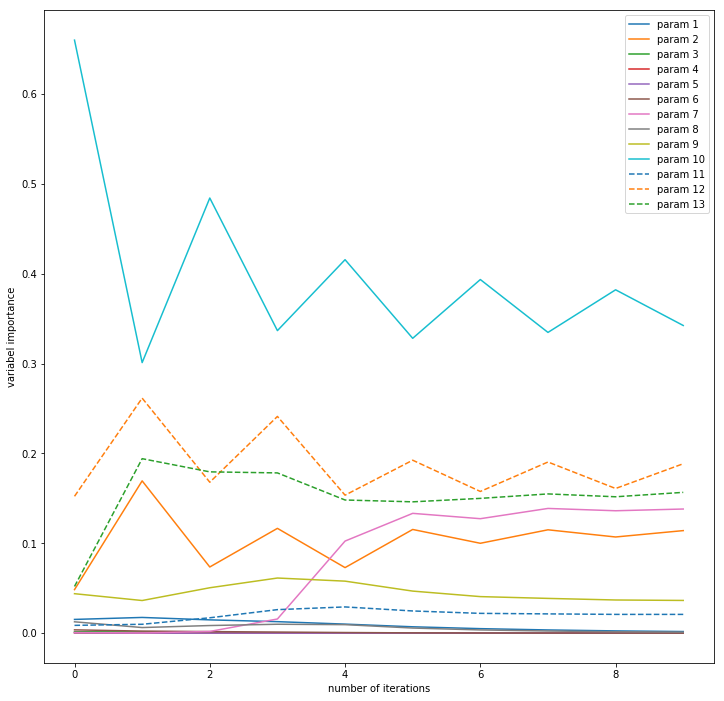

In [13]:
ipw.plot_development()

## Comparison

The comparioson is done with Sklearn and Hoggorm, which as been done to indicate the diffrent result with and without scaling.

Shown Below is the results obtained with scaling wich is done with sklearn and without scaling which is done with Hoggorm. 

Tables of both the rank and the measure of importance have been included for both cases

### sklearn

In [24]:
Importance_Boston_Comp = pd.DataFrame(index =data['feature_names'])
vip = VIP()
smc = sMC()
ipw = IPW()
r = Ridge()
pls = PLSRegression(scale=True)
pls.fit(X,y)

vip.fit(pls)
Importance_Boston_Comp['VIP sklearn'] = vip.importances
smc.fit(pls,X)
Importance_Boston_Comp['sMC sklearn'] = smc.importances

ipw.fit(r,X,y,threshold=0)
Importance_Boston_Comp['IPW sklearn Ridge'] = ipw.importances
Importance_Boston_Comp 


,VIP sklearn,sMC sklearn,IPW sklearn Ridge
CRIM,0.733727,7.962739e+01,1.799166e-03
ZN,0.717301,3.118435e+00,1.141085e-01
INDUS,0.970405,8.159210e+01,1.665880e-10
CHAS,0.570576,5.055341e+02,1.910537e-13
NOX,0.924612,6.285301e+02,3.736411e-26
RM,1.635932,5.192550e+02,1.713835e-05
AGE,0.854793,1.654036e-07,1.381398e-01
DIS,1.051266,3.151353e+02,1.086916e-03
RAD,0.907570,2.132675e+00,3.639848e-02
TAX,0.950611,6.668559e-02,3.423726e-01


In [25]:
Importance_Boston_Comp_no = pd.DataFrame(index =data['feature_names'])
Importance_Boston_Comp_no['VIP sklearn pls'] = np.argsort(np.argsort(vip.importances)[::-1])+1
Importance_Boston_Comp_no['sMC sklearn pls'] = np.argsort(np.argsort(smc.importances)[::-1])+1
Importance_Boston_Comp_no['IPW sklearn Ridge'] = np.argsort(np.argsort(ipw.importances)[::-1])+1
Importance_Boston_Comp_no

,VIP sklearn pls,sMC sklearn pls,IPW sklearn Ridge
CRIM,10,8,8
ZN,11,9,5
INDUS,5,7,11
CHAS,13,5,12
NOX,7,2,13
RM,1,4,10
AGE,9,13,4
DIS,3,6,9
RAD,8,10,6
TAX,6,12,1


### Hoggorm

In [26]:
Importance_Boston_Comp = pd.DataFrame(index =data['feature_names'])
vip = VIP()
smc = sMC()
ipw = IPW()
r = Ridge()
#pls = PLSRegression()
#pls.fit(X,y)
pls =  ho.nipalsPLS1(X, y.reshape(506,1), cvType=['loo'], numComp=2,Xstand=False)

vip.fit(pls)
Importance_Boston_Comp['VIP sklearn'] = vip.importances
smc.fit(pls,X)
Importance_Boston_Comp['sMC sklearn'] = smc.importances

ipw.fit(r,X,y,threshold=0)
Importance_Boston_Comp['IPW sklearn Ridge'] = ipw.importances
Importance_Boston_Comp

loo
loo


,VIP sklearn,sMC sklearn,IPW sklearn Ridge
CRIM,0.171312,720.932559,1.799166e-03
ZN,0.709293,614.697833,1.141085e-01
INDUS,0.177492,1001.570191,1.665880e-10
CHAS,0.005766,388.388473,1.910537e-13
NOX,0.002431,980.569572,3.736411e-26
RM,0.056889,542.168964,1.713835e-05
AGE,0.618079,760.764384,1.381398e-01
DIS,0.021929,0.002350,1.086916e-03
RAD,0.152826,27.029754,3.639848e-02
TAX,3.160193,59.104216,3.423726e-01


In [27]:
Importance_Boston_Comp_no = pd.DataFrame(index =data['feature_names'])
Importance_Boston_Comp_no['VIP hoggorm pls'] = np.argsort(np.argsort(vip.importances)[::-1])+1
Importance_Boston_Comp_no['sMC hoggorm pls'] = np.argsort(np.argsort(smc.importances)[::-1])+1
Importance_Boston_Comp_no['IPW sklearn Ridge'] = np.argsort(np.argsort(ipw.importances)[::-1])+1
Importance_Boston_Comp_no

,VIP hoggorm pls,sMC hoggorm pls,IPW sklearn Ridge
CRIM,7,5,8
ZN,3,7,5
INDUS,6,1,11
CHAS,12,10,12
NOX,13,2,13
RM,10,9,10
AGE,4,3,4
DIS,11,13,9
RAD,8,12,6
TAX,1,11,1


### Visulization

Scaling

In [29]:
vip_scaled = (vip.importances - np.mean(vip.importances))/np.std(vip.importances)
smc_scaled = (smc.importances - np.mean(smc.importances))/np.std(smc.importances)
ipw_scaled = (ipw.importances - np.mean(ipw.importances))/np.std(ipw.importances)

graf

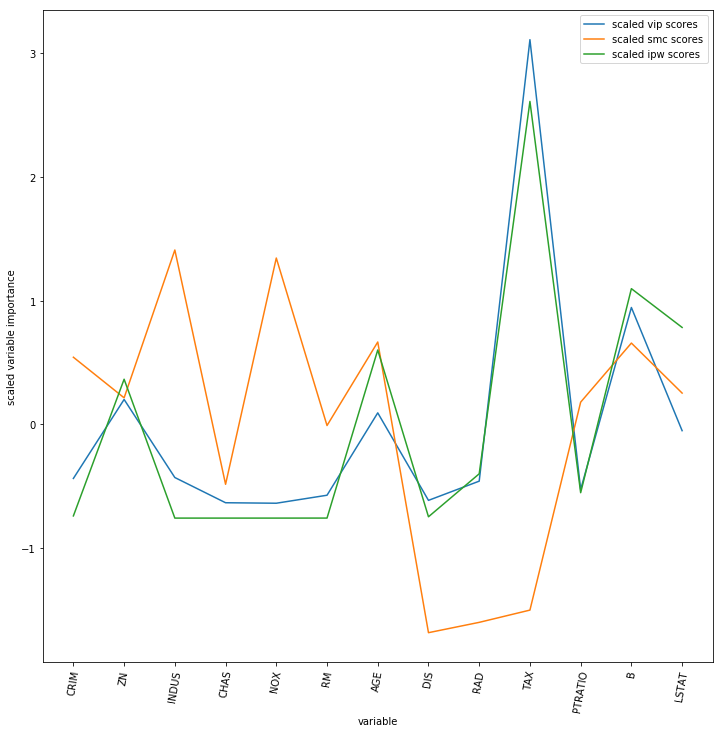

In [30]:
plt.figure(figsize=(12,12))
plt.plot(range(0,13),vip_scaled,label = 'scaled vip scores')
plt.plot(range(0,13),smc_scaled,label = 'scaled smc scores')
plt.plot(range(0,13),ipw_scaled,label = 'scaled ipw scores')
plt.legend(loc='upper right')
plt.xticks(range(X.shape[1]), data['feature_names'], rotation=80)
plt.xlabel('variable')
plt.ylabel('scaled variable importance')
plt.show()

histogram

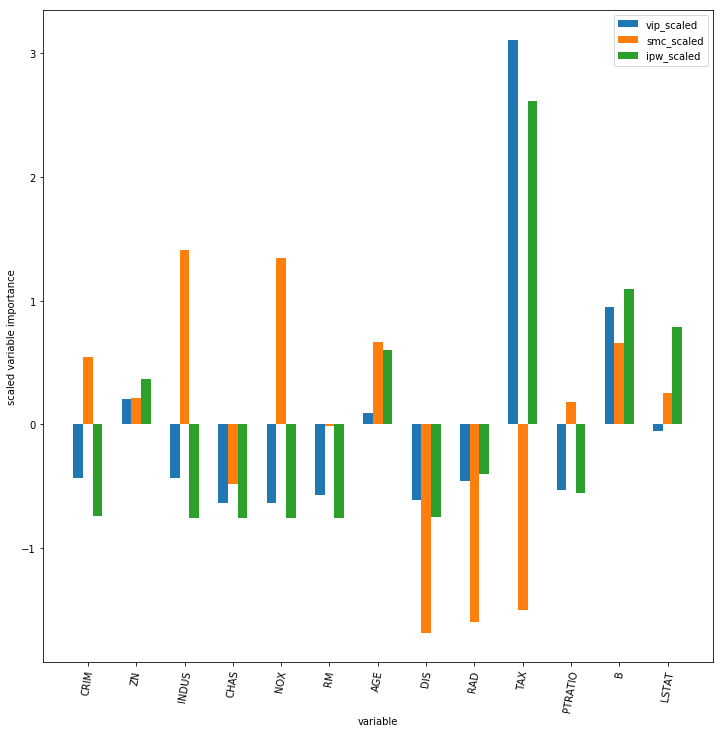

In [55]:
plt.figure(figsize=(12,12))
w = 0.2
plt.bar(np.arange(len(vip_scaled))-w, vip_scaled,width=w, label ='vip_scaled')
plt.bar(np.arange(len(smc_scaled)), smc_scaled,width=w, label ='smc_scaled')
plt.bar(np.arange(len(ipw_scaled))+w, ipw_scaled,width=w, label ='ipw_scaled')
plt.xticks(range(X.shape[1]), data['feature_names'], rotation=80)
plt.yticks(size=10)
plt.legend(loc='upper right')
plt.xlabel('variable')
plt.ylabel('scaled variable importance')
plt.show()

## Effects on Key Peformance Indicators

In [311]:
## introducing efs
r = Ridge()

efs1 = EFS(r, 
           min_features=1,
           max_features=13,
           scoring='neg_mean_absolute_error',#'neg_mean_squared_error',
           print_progress=True,
           cv=5)

#efs1.fit(X_train, y_train)

Features: 8191/8191

ExhaustiveFeatureSelector(clone_estimator=True, cv=5,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
             max_features=13, min_features=1, n_jobs=1,
             pre_dispatch='2*n_jobs', print_progress=True,
             scoring='neg_mean_absolute_error')

In [ ]:
## introducing efs
r1 = Ridge()

efs1 = EFS(r1, 
           min_features=1,
           max_features=13,
           scoring='mean_absolute_error'#'neg_mean_squared_error',
           print_progress=True,
           cv=5)

## Models
baseline = Ridge()
vip_model = Ridge()
smc_model = Ridge()
ipw_model = Ridge()
r_efs = Ridge()
r = Ridge() # for readability used inside the IPW 

## score storage
baseline_scores = []
vip_scores = []
smc_scores = []
ipw_scores = []
efs_score = []

## number of parameters storage
no_param_vip = []
no_param_smc = []
no_param_ipw = []
no_param_efs = []

## time consumption storage
time_vip = []
time_smc = []
time_ipw = []
efs_times = []

storage = {}
for state in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                       test_size=0.3,
                                                       random_state=state)
    
    pls = ho.nipalsPLS1(X_train, y_train.reshape(np.shape(y_train)[0],1), cvType=['loo'], numComp=2)
    vip = VIP()
    smc = sMC()
    ipw = IPW()
    
    #time fit_tranform efs
    t0_efs1 = time.time()
    efs1.fit(X_train, y_train)
    t1_efs1 = time.time()
    efs_times.append(t1_efs1-t0_efs1)
    
    #time fit_tranform vip
    t0 = time.time()
    vip_trans = vip.fit_transform(pls,X_train,threshold=1)
    t1 = time.time()
    time_vip.append(t1-t0)
    
    #time fit_tranform smc
    t0 = time.time()
    smc_trans = smc.fit_transform(pls,X_train,alpha_mc=0.001)
    t1 = time.time()
    time_smc.append(t1-t0)

    #time fit_tranform IPW
    t0 = time.time()
    ipw_trans = ipw.fit_transform(r,X_train,y_train,no_iter=40,threshold=0.05)
    t1 = time.time()
    time_ipw.append(t1-t0)
    
    #Storage of number of parameters
    no_param_vip.append(np.shape(vip_trans)[1])
    no_param_smc.append(np.shape(smc_trans)[1])
    no_param_ipw.append(np.shape(ipw_trans)[1])
    no_param_efs.append(len(efs1.best_idx_))
    
    #transform test data
    vip_test = vip.transform(X_test,threshold=1)
    smc_test = smc.transform(X_test)
    ipw_test = ipw.transform(X_test)
    
    #fit different models to given data
    baseline.fit(X_train,y_train)
    vip_model.fit(vip_trans,y_train)
    smc_model.fit(smc_trans,y_train)
    ipw_model.fit(ipw_trans,y_train)
    r_efs.fit(X_train[:,efs1.best_idx_],y_train)

    storage[str(state)] = data['feature_names'][vip.importances>1]
    
    baseline_scores.append(mean_absolute_error(y_test, baseline.predict(X_test))) 
    vip_scores.append(mean_absolute_error(y_test,vip_model.predict(vip_test)))
    smc_scores.append(mean_absolute_error(y_test,smc_model.predict(smc_test)))
    ipw_scores.append(mean_absolute_error(y_test,ipw_model.predict(ipw_test)))
    efs_score.append(mean_absolute_error(y_test, r_efs.predict(X_test[:,efs1.best_idx_]))) 


In [296]:
print('    avrage mean squared error for baseline model is {0:4f} with std +/-{1:4f}'.format(np.mean(baseline_scores),np.std(baseline_scores)))
print('    avrage mean squared error for vip selection is {0:4f} with std +/-{1:4f}'.format(np.mean(vip_scores),np.std(vip_scores)))
print('    avrage mean squared error for smc selection is {0:4f} with std +/-{1:4f}'.format(np.mean(smc_scores),np.std(smc_scores)))
print('    avrage mean squared error for ipw selection is {0:4f} with std +/-{1:4f}'.format(np.mean(ipw_scores),np.std(ipw_scores)))
print('    avrage mean squared error for efs model is {0:4f} with std +/-{1:4f}'.format(np.mean(efs_score),np.std(efs_score)))

    avrage mean squared error for baseline model is 8.264785 with std +/-3.701695
    avrage mean squared error for vip selection is 5.861383 with std +/-0.379991
    avrage mean squared error for smc selection is 7.227898 with std +/-3.752635
    avrage mean squared error for ipw selection is 6.045653 with std +/-0.650087
    avrage mean squared error for baseline model is 3.453203 with std +/-0.244792


In [304]:
col_names= ['Average mse', 'Standard deviation', 'Average number of features','average time fit_transform']
KPI = pd.DataFrame(index =col_names)
KPI['Baseline'] = pd.Series([np.mean(baseline_scores),np.std(baseline_scores),13,0],index =col_names)
KPI['VIP'] = pd.Series([np.mean(vip_scores),np.std(vip_scores),np.mean(no_param_vip),np.mean(time_vip)],index =col_names)
KPI['sMC'] = pd.Series([np.mean(smc_scores),np.std(smc_scores),np.mean(no_param_smc),np.mean(time_smc)],index =col_names)
KPI['IPW'] = pd.Series([np.mean(ipw_scores),np.std(ipw_scores),np.mean(no_param_ipw),np.mean(time_ipw)],index =col_names)
KPI['EFS'] = pd.Series([np.mean(efs_score),np.std(efs_score),np.mean(no_param_efs),np.mean(efs_times)],index =col_names)
KPI

,Baseline,VIP,sMC,IPW,EFS
Average mse,8.264785,5.861383,7.227898,6.045653,3.453203
Standard deviation,3.701695,0.379991,3.752635,0.650087,0.244792
Average number of features,13.000000,2.020000,12.060000,3.020000,10.310000
average time fit_transform,0.000000,0.000210,0.000791,0.025638,54.709215


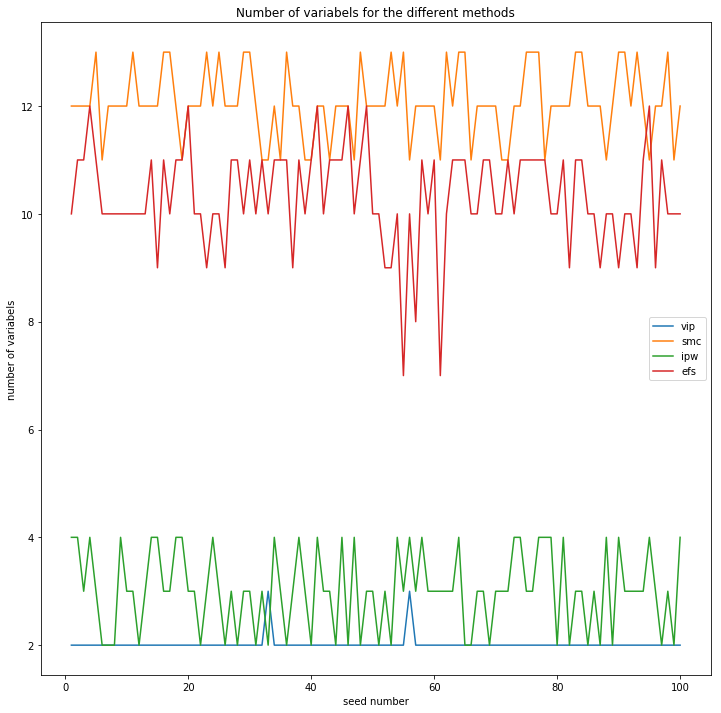

In [247]:
plt.figure(figsize=(12,12))
plt.plot(range(1,101),no_param_vip,label='vip')
plt.plot(range(1,101),no_param_smc,label='smc')
plt.plot(range(1,101),no_param_ipw,label='ipw')
plt.plot(range(1,101),no_param_efs,label='efs')
plt.legend(loc='best')
plt.xlabel('seed number')
plt.ylabel('number of variabels')
plt.title('Number of variabels for the different methods')
plt.show()

### Output from the different PLS algorithms

In [ ]:
    X = data['data']
    y = data['target']
    pls_sklearn = PLSRegression(n_components=13,scale=False)
    pls_sklearn.fit(X,y)
    pls_ho = ho.nipalsPLS1(X,y.reshape(506,1),numComp=13,Xstand=False)

In [ ]:
#Cleared output
print(np.divide(pls_sklearn.x_weights_,pls_ho.arrW))
print(np.divide(pls_sklearn.x_scores_,pls_ho.arrT))
print(pls_sklearn.y_loadings_/pls_ho.arrQ)